In [15]:
import json
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, ADAM, GradientDescent
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

#set seed for pseudorandom number generator
algorithm_globals.random_seed = 42

/tmp/ipykernel_14334/141096005.py:19: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  algorithm_globals.random_seed = 42


Costruisco circuito parametrico ("ansatz"). Questo applica allo stato iniziale una trasformazione unitaria tale per cui lo stato può essere intrecciato in modi diversi a seconda del vettore di parametri del circuito.

In [3]:
def AnsatzBuilder(QubitNumber, Depth):
    return RealAmplitudes(QubitNumber, reps=Depth)

In [4]:
#Ansatz = AnsatzBuilder(5,5)
#Ansatz.decompose().draw("mpl")

Costruisco lo Swaptest. Si tratta di un circuito che ha come output una misura della probabilità che lo stato dei qubit trash sia |0,...,0>.

In [5]:
def SwaptestBuilder(TrashSpaceDimension):
    QubitNumber = 2*TrashSpaceDimension + 1
    QuantReg = QuantumRegister(QubitNumber,"q")
    ClassReg = ClassicalRegister(1,"c")
    SwaptestCircuit = QuantumCircuit(QuantReg, ClassReg)
    AuxiliaryQubitLable = QubitNumber-1
    
    #INITIALIZE REFERENCE QUBITS TO 0
    for i in range(TrashSpaceDimension,2*TrashSpaceDimension): SwaptestCircuit.reset(i)

    #H GATE ON AUXILIARY QUBIT
    SwaptestCircuit.h(AuxiliaryQubitLable)
    #CSWAP GATES BETWEEN TRASH AND REFERENCE QUBITS TARGETING AUXILIARY QUBIT
    for i in range(TrashSpaceDimension):
        SwaptestCircuit.cswap(AuxiliaryQubitLable, i, TrashSpaceDimension+i)
    #H GATE ON AUXILIARY QUBIT
    SwaptestCircuit.h(AuxiliaryQubitLable)
    SwaptestCircuit.measure(AuxiliaryQubitLable, ClassReg[0])

    return SwaptestCircuit


In [6]:
#Swaptest = SwaptestBuilder(2)
#Swaptest.draw("mpl")

Costruisco l'encoder combinando i due circuiti precedenti

In [7]:
def EncoderBuilder(InputStateDimension, EncodedStateDimension, Depth):
    #Calculate dimension of spaces
    LatentSpaceDimension = EncodedStateDimension
    TrashSpaceDimension = InputStateDimension - EncodedStateDimension
    ReferenceSpaceDimension = TrashSpaceDimension
    TotalQubitNumber = LatentSpaceDimension + TrashSpaceDimension + ReferenceSpaceDimension +1 #+1 (for auxiliary qubit)

    #Initialize circuit
    QuantReg = QuantumRegister(TotalQubitNumber,"q")
    ClassReg = ClassicalRegister(1,"c")
    Circuit = QuantumCircuit(QuantReg, ClassReg)

    #Add AnsatzCircuit
    Ansatz = AnsatzBuilder(LatentSpaceDimension+TrashSpaceDimension, Depth)
    Circuit.compose(Ansatz,range(0, InputStateDimension), inplace=True)
    #Barrier to define optimization regions
    Circuit.barrier()
    #Add SwapTestCircuit
    Circuit.compose(SwaptestBuilder(TrashSpaceDimension),range(LatentSpaceDimension, TotalQubitNumber), inplace=True)
    
    return Circuit


/home/codespace/.python/current/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


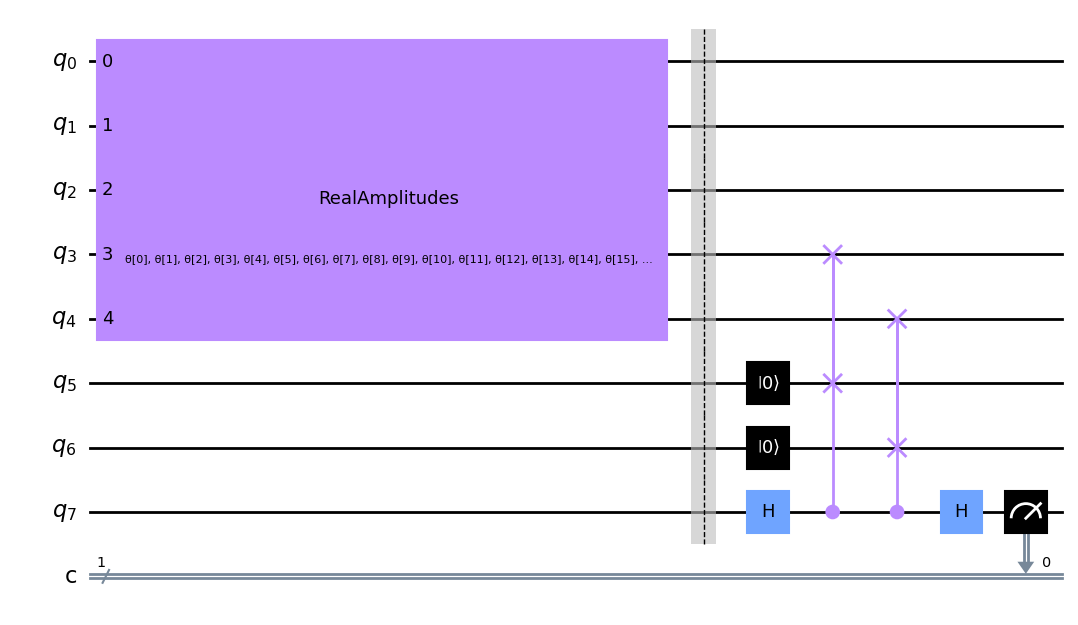

In [8]:
Encoder = EncoderBuilder(5,3,5)
Encoder.draw("mpl")

Esempio |00111>

/home/codespace/.python/current/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


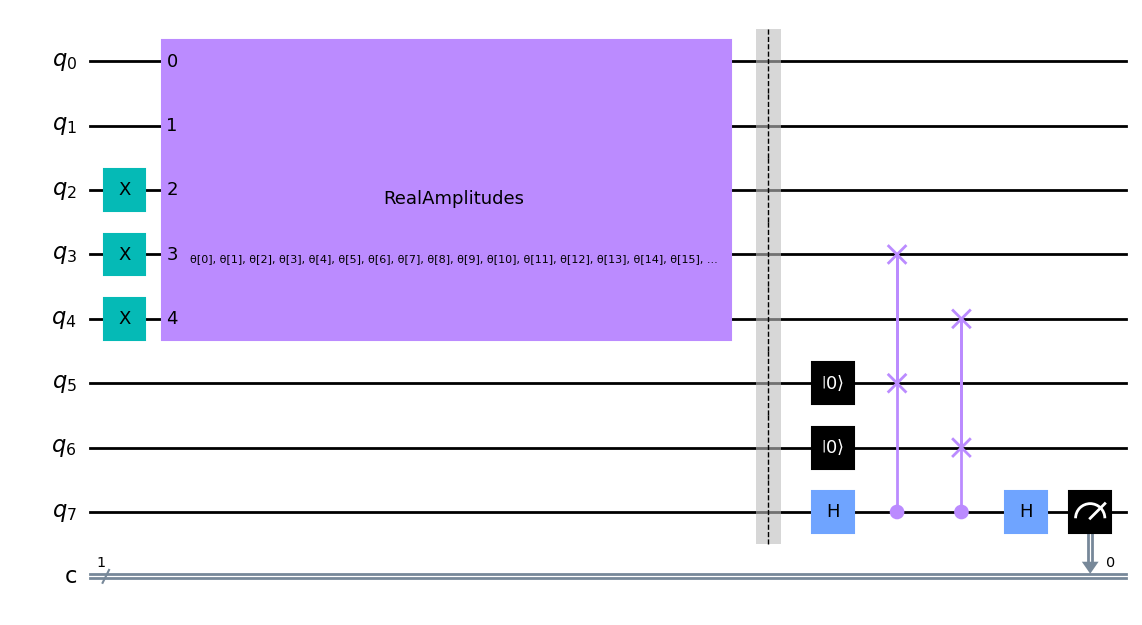

In [9]:
#building initial state
init = QuantumCircuit(5)
for i in range(2,5,1):
    init.x(i)
ae = EncoderBuilder(5,3,5)
#building circuit
circuit = QuantumCircuit(ae.num_qubits)
circuit.compose(init, inplace=True)
circuit.compose(ae, inplace=True)
circuit.draw("mpl")

In [10]:
# Here we define our interpret for our SamplerQNN
def identity_interpret(x):
    return x

qnn = SamplerQNN(
    circuit=circuit,
    input_params=[],
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
)

In [21]:
def cost_func_domain(params_values):
    probabilities = qnn.forward([], params_values)
    # we pick a probability of getting 1 as the output of the network
    cost = np.sum(probabilities[:, 1])

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    
    return cost

In [22]:
opt = ADAM(maxiter=150)
initial_point = algorithm_globals.random.random(ae.num_parameters)

objective_func_vals = []
#make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(cost_func_domain, initial_point)
elapsed = time.time() - start

print(f"Fit in {elapsed:0.2f} seconds")

/tmp/ipykernel_14334/4165558137.py:2: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  initial_point = algorithm_globals.random.random(ae.num_parameters)


Fit in 28.23 seconds


Costruisco circuito di test

In [23]:
#build initial state
init = QuantumCircuit(5)
for i in range(2,5,1):
    init.x(i)
test_circuit = init
#build ansatz and compose with initial state
Ansatz = AnsatzBuilder(5,5)
test_circuit.compose(Ansatz,range(0,5), inplace=True)
test_circuit.barrier()
#reset trash qubits to 0
test_circuit.reset(4)
test_circuit.reset(3)
test_circuit.barrier()
#compose with decoder
test_circuit.compose(Ansatz.inverse(),range(0,5), inplace=True)

test_circuit = test_circuit.assign_parameters(opt_result.x)

In [24]:
input_state = Statevector.from_label('00111').data
output_state = Statevector(test_circuit).data

fidelity = np.sqrt(np.dot(input_state.conj(), output_state) ** 2)
print("Fidelity of our Output State with our Input State: ", fidelity.real)

Fidelity of our Output State with our Input State:  0.02432569131410026
